# Blackjack Model‐Based vs Q‐Learning Experiments

In this notebook we:

- Build and solve the infinite‐deck Blackjack MDP with Value Iteration (VI) and Policy Iteration (PI) for various gamma.
- Visualize convergence (Bellman error & mean value) and plot optimal “hit vs stay” policy heatmaps (usable‐ace vs non‐ace).
- Train a tabular Q‐Learning agent (parameterized by α, γ, ε‐schedule).
- Plot Q‐learning win‐rate vs episodes and compare its final policy to the VI/PI policies.


In [ ]:
# Set parent dir
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Agents & Env
from envs.blackjack_env1 import BlackjackEnv
from agents.value_iteration import value_iteration, policy_iteration
from agents.q_learning_agent import QLearningAgent

# Visualization helpers
import seaborn as sns  # for heatmaps

# Other imports
from tqdm import trange


parent_dir = os.path.dirname(os.getcwd())
figures_dir = os.path.join(parent_dir, 'figures')

## Model‐Based: VI vs PI Convergence

### Bellman‐Error & Mean‐Value

We sweep γ∈{0.8, 0.9, 1.0}, run VI and PI, and record per‐iteration Bellman‐error (∆) and average state‐value.


In [2]:
gammas = [0.8, 0.9, 1.0]
vi_stats = {}
pi_stats = {}

for γ in gammas:
    # Value Iteration
    V_vi, π_vi, vi_run_stats = value_iteration(gamma=γ, theta=1e-6, return_stats=True)
    vi_stats[γ] = vi_run_stats
    
    # Policy Iteration
    V_pi, π_pi, pi_run_stats = policy_iteration(gamma=γ, theta=1e-6, return_stats=True)
    pi_stats[γ] = pi_run_stats


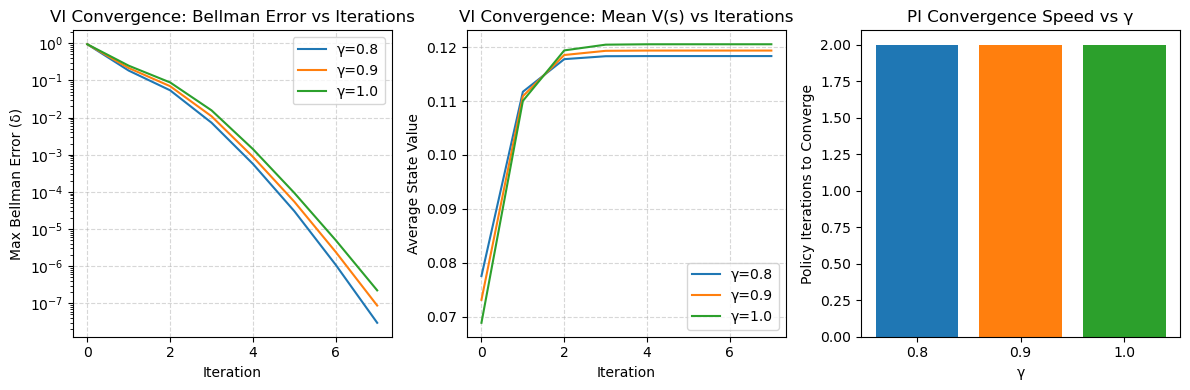

In [3]:
gammas = [0.8, 0.9, 1.0]

# Create subplots: 1 row, 3 columns, taller than wider
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 1) Plot Bellman‐error (delta) curves for VI
for γ in gammas:
    deltas = vi_stats[γ]['deltas']
    axes[0].plot(deltas, label=f'γ={γ}')
axes[0].set_yscale('log')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Max Bellman Error (δ)')
axes[0].set_title('VI Convergence: Bellman Error vs Iterations')
axes[0].legend()
axes[0].grid(True, ls='--', alpha=0.5)

# 2) Plot mean V(s) curves for VI
for γ in gammas:
    means = vi_stats[γ]['mean_values']
    axes[1].plot(means, label=f'γ={γ}')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Average State Value')
axes[1].set_title('VI Convergence: Mean V(s) vs Iterations')
axes[1].legend()
axes[1].grid(True, ls='--', alpha=0.5)

# 3) Plot number of policy‐improvement cycles for PI
iterations = [pi_stats[γ]['policy_iterations'] for γ in gammas]
# Use same colors as VI plots: C0 (blue), C1 (orange), C2 (green)
bar_colors = ['C0', 'C1', 'C2']  # Same as default matplotlib color cycle
bars = axes[2].bar([str(γ) for γ in gammas], iterations, color=bar_colors)
axes[2].set_xlabel('γ')
axes[2].set_ylabel('Policy Iterations to Converge')
axes[2].set_title('PI Convergence Speed vs γ')

# Adjust layout to prevent overlap
plt.tight_layout()

# Export figure with high resolution
os.makedirs(figures_dir, exist_ok=True)  # Create directory if it doesn't exist
plt.savefig(os.path.join(figures_dir, "vi_pi_convergence_comparison.png"), 
            dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

VI Bellman‐error curves

All three curves drop exponentially to zero in about 7–8 sweeps.

The lower γ (blue, 0.8) curve falls slightly faster than γ=0.9 (orange), and γ=1.0 (green) is the slowest—because with a smaller discount you’re propagating “future” rewards less, so the max‐error contracts more strongly each iteration.

VI Mean‐value curves

Every curve rises from its initial ≈0 to a stable plateau in about 2–3 sweeps.

The higher γ gives a higher average state‐value (green > orange > blue), since you care more about future outcomes.

PI Convergence

All three γ’s converged in 2 policy‐improvement sweeps, so each bar sits at “2.” That’s also expected—Policy Iteration often needs very few passes to find the exact optimal policy once you can evaluate the current policy exactly.



## Model‐Based: Policy Heatmaps

Plot two 10×10 grids (“dealer up” vs “player sum”) colored by action (0=stay grey, 1=hit green), separately for usable‐ace=False and True.

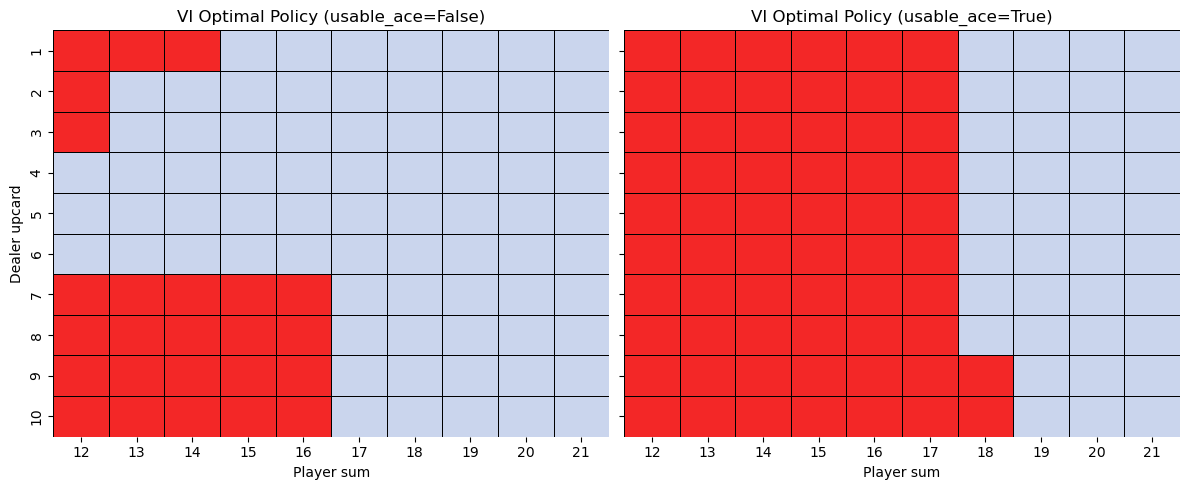

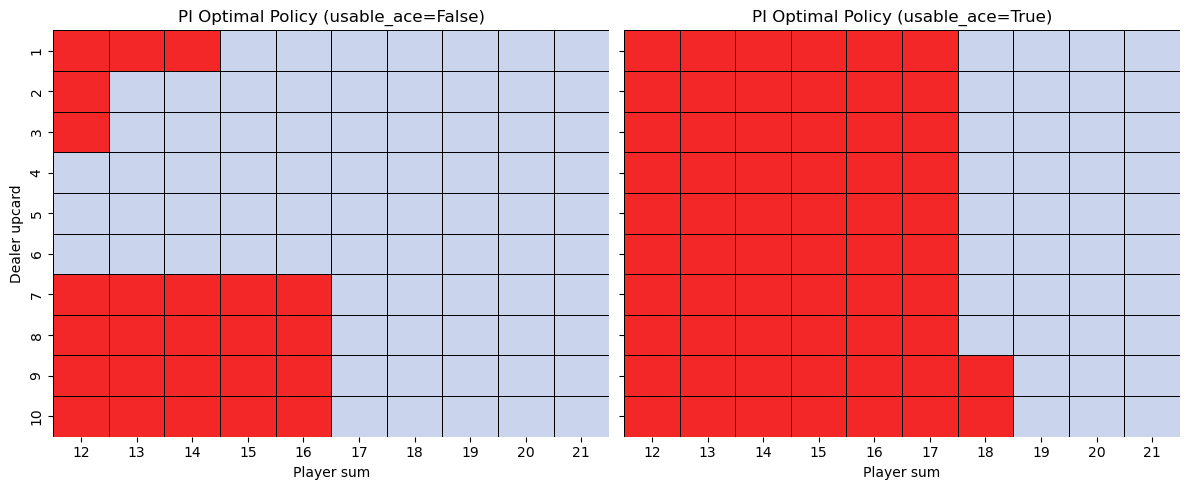

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# your colors:
STAY_COLOR = "#CAD5ED"   # blue
HIT_COLOR  = "#F32727"   # red

cmap = ListedColormap([STAY_COLOR, HIT_COLOR])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

def plot_policy_heatmap(pi, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    for idx, ua in enumerate([False, True]):
        data = np.zeros((10, 10))
        for i, du in enumerate(range(1, 11)):
            for j, ps in enumerate(range(12, 22)):
                data[i, j] = pi[(ps, du, ua)]
        sns.heatmap(
            data,
            cmap=cmap,
            norm=norm,
            cbar=False,
            xticklabels=range(12, 22),
            yticklabels=range(1, 11),
            linewidths=0.5,
            linecolor='black',
            ax=axes[idx]
        )
        axes[idx].set_xlabel('Player sum')
        axes[idx].set_title(f'{title} (usable_ace={ua})')
    axes[0].set_ylabel('Dealer upcard')
    plt.tight_layout()
    plt.show()


plot_policy_heatmap(π_vi, 'VI Optimal Policy')
plot_policy_heatmap(π_pi, 'PI Optimal Policy')


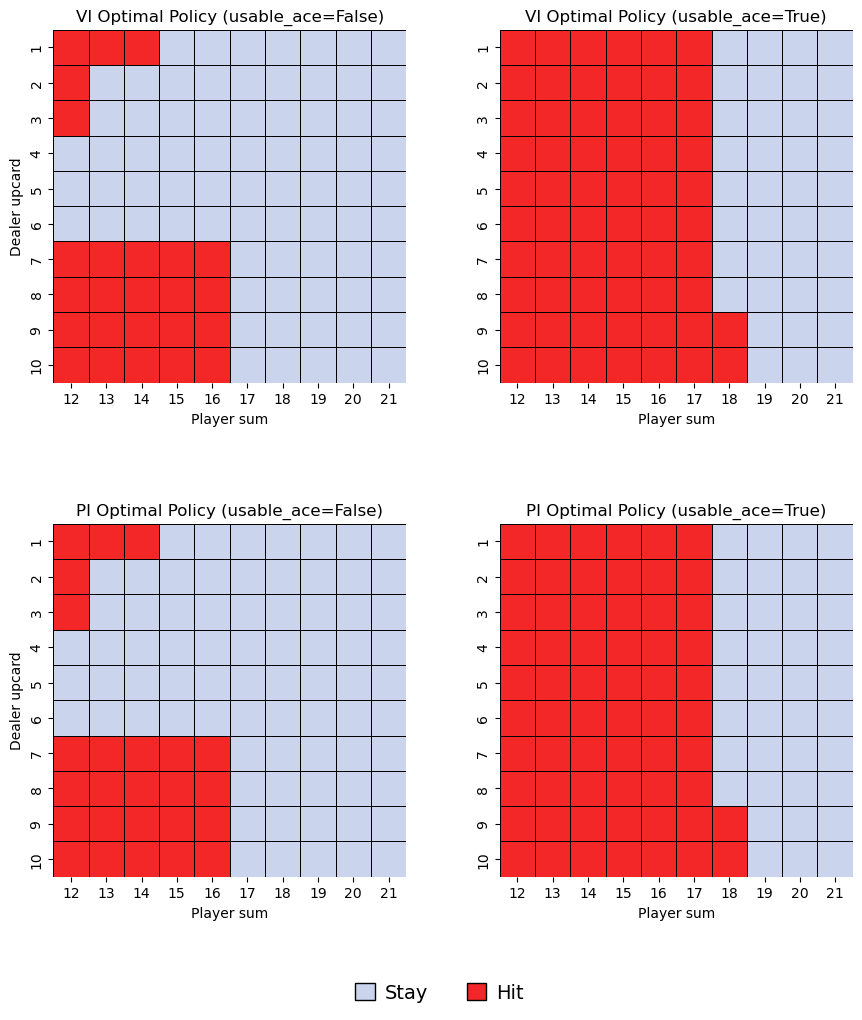

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle

# your colors:
STAY_COLOR = "#CAD5ED"   # blue
HIT_COLOR  = "#F32727"   # red

cmap = ListedColormap([STAY_COLOR, HIT_COLOR])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

def plot_policy_comparison(pi_vi, pi_pi):
    # Create 2x2 subplots with extra spacing
    fig, axes = plt.subplots(2, 2, figsize=(11, 11), 
                            gridspec_kw={'hspace': 0.4, 'wspace': 0.1})
    
    # VI policies (top row)
    for idx, ua in enumerate([False, True]):
        data = np.zeros((10, 10))
        for i, du in enumerate(range(1, 11)):
            for j, ps in enumerate(range(12, 22)):
                data[i, j] = pi_vi[(ps, du, ua)]
        
        sns.heatmap(
            data,
            cmap=cmap,
            norm=norm,
            cbar=False,
            xticklabels=range(12, 22),
            yticklabels=range(1, 11),
            linewidths=0.5,
            linecolor='black',
            ax=axes[0, idx],
            square=True  # Make cells square
        )
        axes[0, idx].set_xlabel('Player sum')
        axes[0, idx].set_title(f'VI Optimal Policy (usable_ace={ua})')
        if idx == 0:
            axes[0, idx].set_ylabel('Dealer upcard')
    
    # PI policies (bottom row)
    for idx, ua in enumerate([False, True]):
        data = np.zeros((10, 10))
        for i, du in enumerate(range(1, 11)):
            for j, ps in enumerate(range(12, 22)):
                data[i, j] = pi_pi[(ps, du, ua)]
        
        sns.heatmap(
            data,
            cmap=cmap,
            norm=norm,
            cbar=False,
            xticklabels=range(12, 22),
            yticklabels=range(1, 11),
            linewidths=0.5,
            linecolor='black',
            ax=axes[1, idx],
            square=True  # Make cells square
        )
        axes[1, idx].set_xlabel('Player sum')
        axes[1, idx].set_title(f'PI Optimal Policy (usable_ace={ua})')
        if idx == 0:
            axes[1, idx].set_ylabel('Dealer upcard')
    
    # Add legend below the figure
    legend_elements = [
        Rectangle((0, 0), 1, 1, facecolor=STAY_COLOR, edgecolor='black', label='Stay'),
        Rectangle((0, 0), 1, 1, facecolor=HIT_COLOR, edgecolor='black', label='Hit')
    ]

    # Position legend below the subplots, with square handles
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        fontsize=14,
        handlelength=1.0,
        handleheight=1.0,
        handletextpad=0.5,
        borderaxespad=0.5,
        frameon=False
    )
    # Export figure with high resolution
    os.makedirs(figures_dir, exist_ok=True)
    plt.savefig(os.path.join(figures_dir, "vi_pi_policy_heatmaps.png"), 
                dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

# Call the function with both policies
plot_policy_comparison(π_vi, π_pi)

## Q‐Learning Experiments

### Train & Win‐Rate Curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from envs.blackjack_env import BlackjackEnv
from agents.q_learning_agent import QLearningAgent

# Create environment
env = BlackjackEnv(natural=True, num_decks=1)

# Compute alpha_decay so alpha goes 0.1 → 0.001 over 100k episodes
initial_alpha = 0.1
final_alpha   = 1e-3
episodes      = 10_000_000 # 1_000_000
alpha_decay   = (initial_alpha - final_alpha) / episodes  # ≈9.9e-7
initial_epsilon = 1.0
final_epsilon   = 0.01
epsilon_decay   = 1e-5

# Instantiate agent with both alpha- and epsilon-decay
agent = QLearningAgent(
    action_count       = 2,
    initial_alpha      = initial_alpha,
    final_alpha        = final_alpha,
    alpha_decay        = alpha_decay,
    alpha_decay_type   = 'linear',
    gamma              = 1.0,
    initial_epsilon    = initial_epsilon,
    final_epsilon      = final_epsilon,
    epsilon_decay      = epsilon_decay,
    decay_type         = 'linear',
    seed               = 42
)

# Training + periodic evaluation
nc_win_rates = []
for ep in range(episodes):
    state, done = env.reset(), False
    while not done:
        a, ns = agent.select_action(state), None
        ns, r, done, _ = env.step(a)
        agent.update(state, a, r, ns, done)
        state = ns

    # decay both exploration and learning rates
    agent.decay_epsilon()
    agent.decay_alpha()

    # every 1k episodes, evaluate greedy policy
    if ep % 100_000 == 0:
        wins = 0
        for _ in range(50_000):
            s, d = env.reset(), False
            while not d:
                a, s, d = agent.select_action(s, greedy=True), None, None
                s, r, d, _ = env.step(a)
            if r > 0:
                wins += 1
        nc_win_rates.append(wins / 50_000)


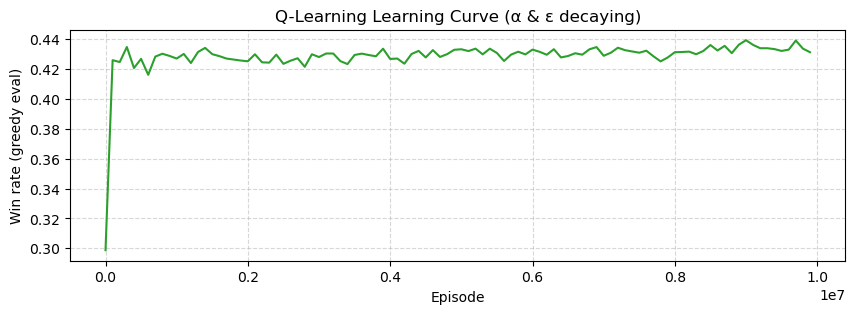

In [7]:
#Plot the final learning curve
plt.figure(figsize=(10, 3))
plt.plot(np.arange(0, episodes, 100000), nc_win_rates, color='C2')
plt.xlabel('Episode')
plt.ylabel('Win rate (greedy eval)')
plt.title('Q-Learning Learning Curve (α & ε decaying)')
plt.grid(True, ls='--', alpha=0.5)

# Save
plt.savefig(os.path.join(figures_dir, "q_learning_learning_curve.png"), 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

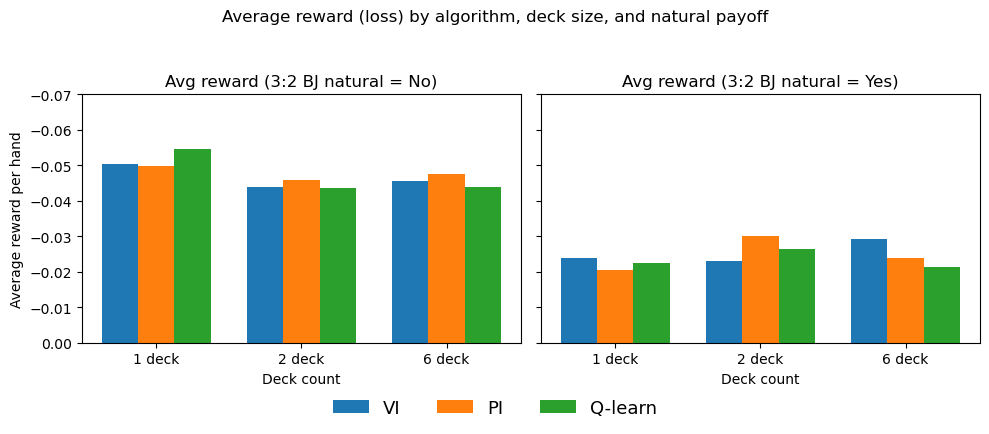

In [8]:
def evaluate_policy(env, policy, n_games=50_000):
    """
    Play n_games hands in env using policy (a dict state->action),
    return fraction of hands with reward>0.
    States with player_sum < 12 are forced to Hit.
    """
    wins = 0
    for _ in range(n_games):
        s, done = env.reset(), False
        while not done:
            # If sum <12, always hit
            if s[0] < 12:
                a = 1
            else:
                a = policy.get(s, 1)   # fallback to Hit if missing
            s, r, done, _ = env.step(a)
        if r > 0:
            wins += 1
    return wins / n_games



def evaluate_performance(env, policy, n_games=50_000):
    """
    Play n_games hands in `env` using `policy` (a dict state->action),
    return the average reward per hand.
    States with player_sum < 12 are forced to Hit.
    """
    total_reward = 0.0
    for _ in range(n_games):
        s, done = env.reset(), False
        while not done:
            # If sum <12, always hit
            if s[0] < 12:
                a = 1
            else:
                a = policy.get(s, 1)   # fallback to Hit if missing
            s, r, done, _ = env.step(a)
        total_reward += r
    return total_reward / n_games


from collections import OrderedDict

# 1) Get the three policies
vi_V, vi_policy     = value_iteration()
_, pi_policy, _     = policy_iteration(return_stats=True)
q_policy            = agent.get_policy()

algos = OrderedDict([
    ('VI',      vi_policy),
    ('PI',      pi_policy),
    ('Q-learn', q_policy)
])

deck_sizes = [1, 2, 6]
naturals    = [False, True]

# store results: results[(algo,natural,deck)] = avg_reward
results = {}

for nat in naturals:
    for decks in deck_sizes:
        env = BlackjackEnv(natural=nat, num_decks=decks, reshuffle_threshold=10)
        for name, policy in algos.items():
            avg_r = evaluate_performance(env, policy, n_games=50_000)
            results[(name, nat, decks)] = avg_r

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

x = np.arange(len(deck_sizes))    # positions for 1,2,6 decks
width = 0.25

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

for i, nat in enumerate(naturals):
    ax = axes[i]
    for j, (name, _) in enumerate(algos.items()):
        # extract avg rewards for this algo & natural across deck_sizes
        avgs = [ results[(name, nat, d)] for d in deck_sizes ]
        ax.bar(x + j*width, avgs, width, label=name)
    ax.set_xticks(x + width)
    ax.set_xticklabels([f'{d} deck' for d in deck_sizes])
    ax.set_ylim(0, -0.07)  # y-axis from 0 to 1
    ax.set_xlabel('Deck count')
    ax.set_title(f'Avg reward (3:2 BJ natural = {"Yes" if nat else "No"})')

axes[0].set_ylabel('Average reward per hand')

# Custom legend below the plot, centered, single row, no box around color
fig.legend(
    handles=[
        Patch(facecolor='C0', edgecolor='none', label='VI'),
        Patch(facecolor='C1', edgecolor='none', label='PI'),
        Patch(facecolor='C2', edgecolor='none', label='Q-learn')
    ],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=3,
    fontsize=13,
    frameon=False
)
plt.suptitle('Average reward (loss) by algorithm, deck size, and natural payoff')
plt.tight_layout(rect=[0,0,1,0.93])
fig.savefig(f"{figures_dir}/avg_reward_by_algo_deck_natural.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


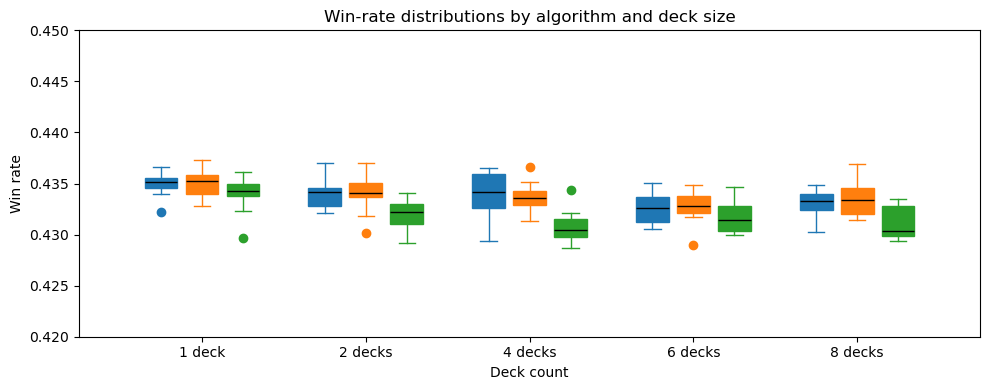

In [9]:
# Number of independent policy‐evaluation runs per (algo,deck)
n_eval_runs = 10  

# More deck sizes to compare
deck_sizes = [1, 2, 4, 6, 8]

# Prepare storage: a list of win‐rate samples for each combination
results = { (name, decks): [] 
            for name in algos 
            for decks in deck_sizes }

# Gather samples (using natural=True since win rates are the same either way)
for decks in deck_sizes:
    env = BlackjackEnv(natural=True, num_decks=decks, reshuffle_threshold=10)
    for name, policy in algos.items():
        samples = []
        for _ in range(n_eval_runs):
            wr = evaluate_policy(env, policy, n_games=100_000)
            samples.append(wr)
        results[(name, decks)] = samples

# Plot boxplots
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

x = np.arange(len(deck_sizes))      # [0,1,2,3,4]
width = 0.25                        # group width

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for j, name in enumerate(algos):
    # positions for each deck at this algorithm's offset
    positions = x + j*width
    # collect the n_eval_runs samples for each deck size
    data = [ results[(name, d)] for d in deck_sizes ]
    # draw boxplot
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=width*0.8,
        patch_artist=True,
        boxprops=dict(facecolor=f'C{j}', edgecolor=f'C{j}'),
        whiskerprops=dict(color=f'C{j}'),
        capprops=dict(color=f'C{j}'),
        medianprops=dict(color='black'),
        flierprops=dict(marker='o', markerfacecolor=f'C{j}', markeredgecolor=f'C{j}')
    )

ax.set_xticks(x + width)
ax.set_xticklabels([f'{d} deck{"s" if d > 1 else ""}' for d in deck_sizes])
ax.set_ylim(0.42, 0.45)
ax.set_xlabel('Deck count')
ax.set_ylabel('Win rate')
ax.set_title('Win-rate distributions by algorithm and deck size')

# # Shared legend
# fig.legend(
#     handles=[
#         Patch(facecolor='C0', label='VI'),
#         Patch(facecolor='C1', label='PI'),
#         Patch(facecolor='C2', label='Q-learn'),
#     ],
#     loc='upper right',
#     bbox_to_anchor=(0.98, 0.98),
#     frameon=False
# )

plt.tight_layout()

# Export figure
fig_out_path = os.path.join(figures_dir, "winrate_boxplot_comparison.png")
plt.savefig(fig_out_path, dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

## Q‐Learning vs VI/PI Policy Comparison

Extract the final Q‐policy and plot its heatmaps side‐by‐side with the VI/PI ones. Report final win‐rates of each.

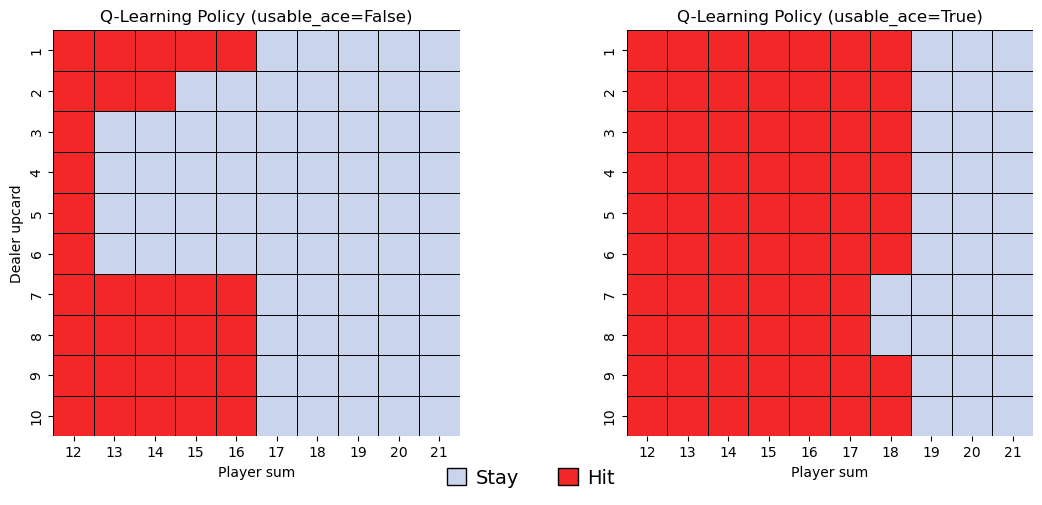

In [10]:
def plot_policy_heatmap(pi, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    for idx, ua in enumerate([False, True]):
        data = np.zeros((10, 10))
        for i, du in enumerate(range(1, 11)):
            for j, ps in enumerate(range(12, 22)):
                data[i, j] = pi[(ps, du, ua)]
        sns.heatmap(
            data,
            cmap=cmap,
            norm=norm,
            cbar=False,
            xticklabels=range(12, 22),
            yticklabels=range(1, 11),
            linewidths=0.5,
            linecolor='black',
            ax=axes[idx],
            square=True  # Make cells square
        )
        axes[idx].set_xlabel('Player sum')
        axes[idx].set_title(f'{title} (usable_ace={ua})')
    axes[0].set_ylabel('Dealer upcard')

    
    # Add legend below the figure
    legend_elements = [
        Rectangle((0, 0), 1, 1, facecolor=STAY_COLOR, edgecolor='black', label='Stay'),
        Rectangle((0, 0), 1, 1, facecolor=HIT_COLOR, edgecolor='black', label='Hit')
    ]

    # Position legend below the subplots, with square handles
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        fontsize=14,
        handlelength=1.0,
        handleheight=1.0,
        handletextpad=0.5,
        borderaxespad=0.5,
        frameon=False
    )



    plt.tight_layout()

    # Export figure
    figout_path = os.path.join(figures_dir, "qlearning_heatmap.png")
    plt.savefig(figout_path, dpi=300, bbox_inches='tight', facecolor='white')

    plt.show()


pi_q = agent.get_policy()
#print("Final Q-Learning Win %:", win_rates[-1])

plot_policy_heatmap(pi_q, 'Q-Learning Policy')

# Task 2 - Card Counting

This is the case where we implement a simple card counting method.

In [11]:
from envs.blackjack_env1 import BlackjackEnv

# Configure Hi-Lo thresholds for single deck
BlackjackEnv.LO_COUNT_THRESHOLD = -3
BlackjackEnv.HI_COUNT_THRESHOLD = +3


# Hyperparameters (match plain Q-learning)
initial_alpha   = 0.1
final_alpha     = 1e-3
episodes        = 10_000_000
alpha_decay     = (initial_alpha - final_alpha) / episodes
initial_epsilon = 1.0
final_epsilon   = 0.01
epsilon_decay   = 1e-5

# Instantiate env & agent
env = BlackjackEnv(natural=True, num_decks=1, reshuffle_threshold=10)
agent = QLearningAgent(
    action_count       = 2,
    initial_alpha      = initial_alpha,
    final_alpha        = final_alpha,
    alpha_decay        = alpha_decay,
    alpha_decay_type   = 'linear',
    gamma              = 1.0,
    initial_epsilon    = initial_epsilon,
    final_epsilon      = final_epsilon,
    epsilon_decay      = epsilon_decay,
    decay_type         = 'linear',
    seed               = 42
)

# Training loop with periodic greedy evaluation
eval_interval = 100_000
cc_win_rates = []
for ep in trange(episodes):
    state, done = env.reset(), False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state

    agent.decay_epsilon()
    agent.decay_alpha()

    if (ep + 1) % eval_interval == 0:
        wins = 0
        for _ in range(50_000):
            s, d = env.reset(), False
            while not d:
                a = agent.select_action(s, greedy=True)
                s, r, d, _ = env.step(a)
            wins += (r > 0)
        cc_win_rates.append(wins / 50_000)


100%|██████████| 10000000/10000000 [03:39<00:00, 45555.94it/s]


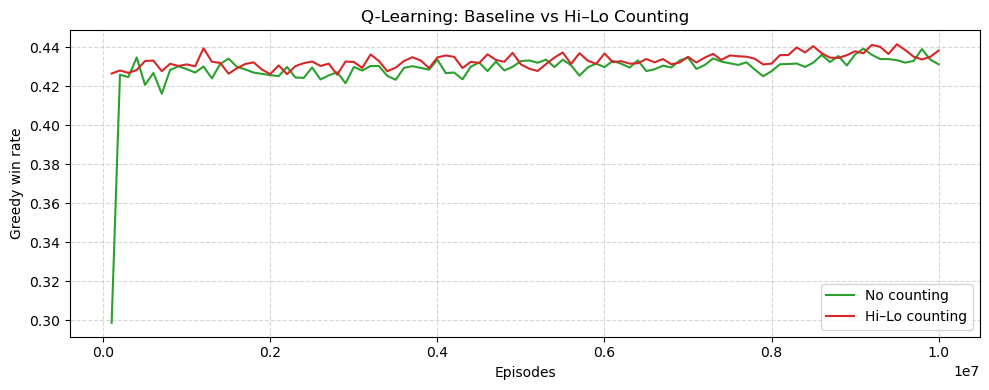

In [27]:
episodes = np.arange(100_000, 10_000_001, 100_000)
baseline_wr = nc_win_rates
counting_wr = cc_win_rates

plt.figure(figsize=(10,4))
plt.plot(episodes, baseline_wr, color='C2', label='No counting')
plt.plot(episodes, counting_wr, color='C3', label='Hi–Lo counting')
plt.xlabel('Episodes')
plt.ylabel('Greedy win rate')
plt.title('Q-Learning: Baseline vs Hi–Lo Counting')
plt.legend()
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(figures_dir, "q_learning_counting_comparison.png"), 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [13]:
# Final overall win-rate
policy = agent.get_policy()
def evaluate_policy(env, policy, n_games=50_000):
    wins = 0
    for _ in range(n_games):
        s, done = env.reset(), False
        while not done:
            if s[0] < 12:
                a = 1
            else:
                a = policy.get(s, 1)
            s, r, done, _ = env.step(a)
        wins += (r > 0)
    return wins / n_games

final_wr = evaluate_policy(env, policy, n_games=100_000)
print(f"Counting agent final win rate: {final_wr:.3%}")

Counting agent final win rate: 43.563%


/var/folders/p4/hc0h0w593bq6hlvxqkwd7_5m0000gn/T/ipykernel_23436/2073165825.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.95])


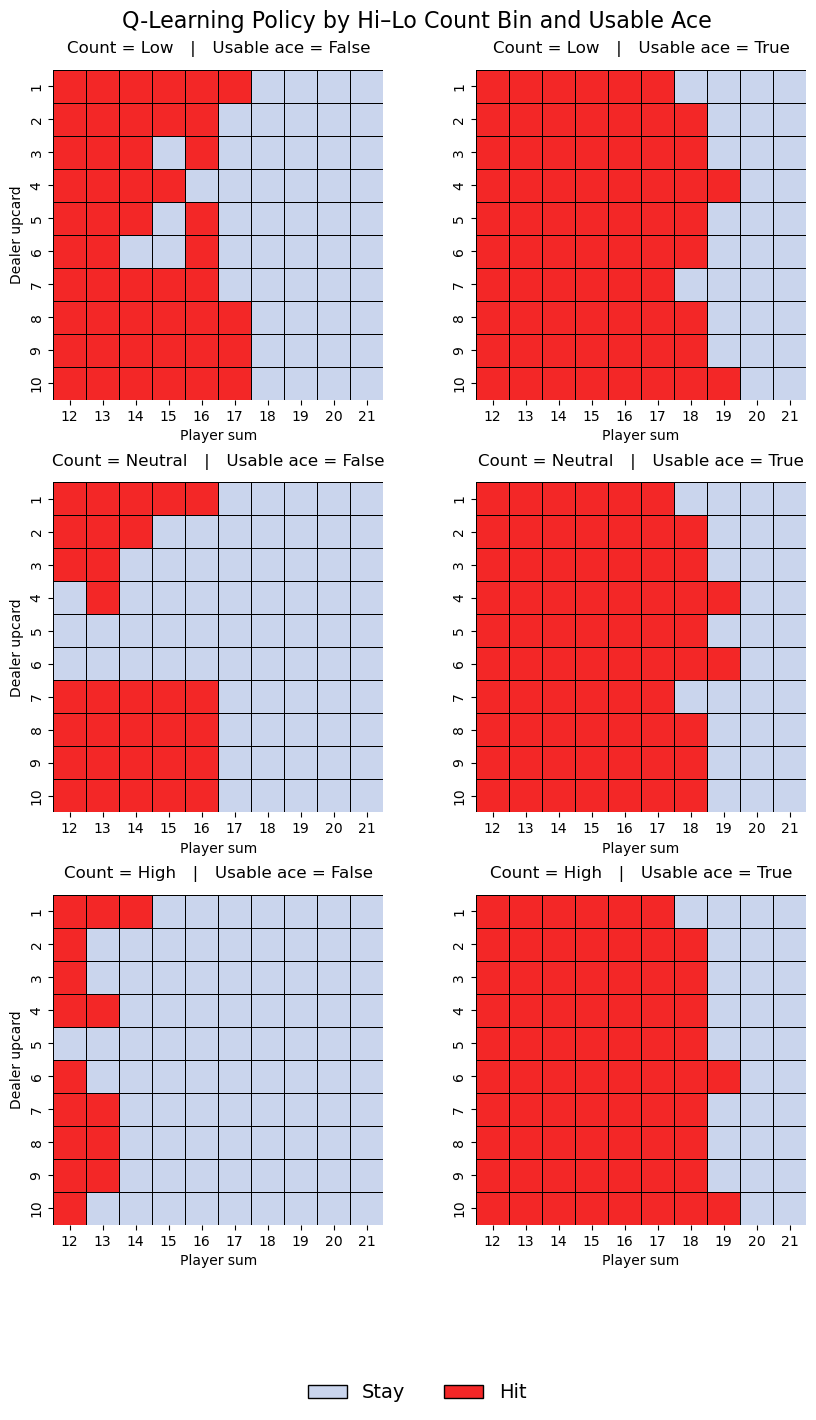

In [23]:
STAY_COLOR = "#CAD5ED"
HIT_COLOR  = "#F32727"
cmap       = ListedColormap([STAY_COLOR, HIT_COLOR])
norm       = BoundaryNorm([0, 0.5, 1], cmap.N)


import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle

# reuse your colors & norm
STAY_COLOR = "#CAD5ED"
HIT_COLOR  = "#F32727"
cmap       = ListedColormap([STAY_COLOR, HIT_COLOR])
norm       = BoundaryNorm([0, 0.5, 1], cmap.N)

# count‐bin labels in the order you trained
bins = ["Low", "Neutral", "High"]

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(10, 15),
    gridspec_kw={'hspace':0.25, 'wspace':0.2},
    sharex=False, sharey=False
)

for bi, count_bin in enumerate(bins):
    for ui, usable in enumerate([False, True]):
        ax = axes[bi, ui]
        data = np.zeros((10, 10), dtype=int)
        # fill data[i,j] = 0 (stay) or 1 (hit)
        for i, du in enumerate(range(1, 11)):
            for j, ps in enumerate(range(12, 22)):
                state = (ps, du, usable, count_bin)
                data[i, j] = policy.get(state, 0)
        sns.heatmap(
            data,
            ax=ax,
            cmap=cmap,
            norm=norm,
            cbar=False,
            xticklabels=range(12, 22),
            yticklabels=range(1, 11),
            linewidths=0.5,
            linecolor='black',
            square=True
        )
        ax.set_title(f'Count = {count_bin} | Usable ace = {usable}', pad=12)
        ax.set_xlabel('Player sum')
        if ui == 0:
            ax.set_ylabel('Dealer upcard')
        else:
            ax.set_ylabel('')

# single legend below all subplots
legend_handles = [
    Rectangle((0,0),1,1, facecolor=STAY_COLOR, edgecolor='black', label='Stay'),
    Rectangle((0,0),1,1, facecolor=HIT_COLOR,  edgecolor='black', label='Hit')
]
fig.legend(
    handles=legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=2,
    frameon=False,
    fontsize=14
)

fig.suptitle('Q-Learning Policy by Hi–Lo Count Bin and Usable Ace', y=0.92, fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])

# save high-res
os.makedirs(figures_dir, exist_ok=True)
fig.savefig(
    os.path.join(figures_dir, 'counting_policy_heatmaps.png'),
    dpi=300, bbox_inches='tight', facecolor='white'
)

plt.show()



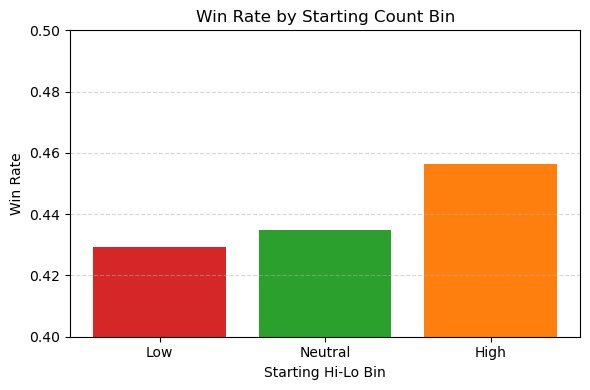

In [26]:
# 7) Bin-conditioned performance
n_eval = 1_000_000
bin_results = {b: {'wins':0, 'count':0} for b in bins}
for _ in range(n_eval):
    s, done = env.reset(), False
    start_bin = s[3]
    bin_results[start_bin]['count'] += 1
    while not done:
        if s[0] < 12:
            a = 1
        else:
            a = policy.get(s,1)
        s, r, done, _ = env.step(a)
    if r > 0:
        bin_results[start_bin]['wins'] += 1

# Compute win rates per bin
bin_wr = {b: bin_results[b]['wins']/bin_results[b]['count'] 
          for b in bins}

# Plot bar chart
plt.figure(figsize=(6,4))
plt.bar(bin_wr.keys(), bin_wr.values(), color=['C3','C2','C1'])
plt.ylim(0,1)
plt.xlabel('Starting Hi-Lo Bin')
plt.ylabel('Win Rate')
plt.ylim(0.4, 0.5)
plt.title('Win Rate by Starting Count Bin')
plt.grid(axis='y', ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'bin_conditioned_winrates.png'), dpi=300)
plt.show()